In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files
files.upload()  # This will prompt you to upload the kaggle.json file

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"malisettiramnarayana","key":"c3d2e12149cec467002e5b4fd3a51681"}'}

In [ ]:
!pip install kaggle  # Install the Kaggle package
!mkdir -p ~/.kaggle  # Make a directory for the Kaggle API key
!cp kaggle.json ~/.kaggle/  # Copy the uploaded kaggle.json to this directory
!chmod 600 ~/.kaggle/kaggle.json  # Change the permissions of the file

In [ ]:
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection
!unzip brain-mri-images-for-brain-tumor-detection.zip

Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
License(s): copyright-authors
 79% 12.0M/15.1M [00:00<00:00, 22.2MB/s]
100% 15.1M/15.1M [00:00<00:00, 16.8MB/s]
Archive:  brain-mri-images-for-brain-tumor-detection.zip
  inflating: brain_tumor_dataset/no/1 no.jpeg  
  inflating: brain_tumor_dataset/no/10 no.jpg  
  inflating: brain_tumor_dataset/no/11 no.jpg  
  inflating: brain_tumor_dataset/no/12 no.jpg  
  inflating: brain_tumor_dataset/no/13 no.jpg  
  inflating: brain_tumor_dataset/no/14 no.jpg  
  inflating: brain_tumor_dataset/no/15 no.jpg  
  inflating: brain_tumor_dataset/no/17 no.jpg  
  inflating: brain_tumor_dataset/no/18 no.jpg  
  inflating: brain_tumor_dataset/no/19 no.jpg  
  inflating: brain_tumor_dataset/no/2 no.jpeg  
  inflating: brain_tumor_dataset/no/20 no.jpg  
  inflating: brain_tumor_dataset/no/21 no.jpg  
  inflating: brain_tumor_dataset/no/22 no.jpg  
  inflating: brain_tumor_dataset/no/23 no.jpg  
  inflating: b

In [ ]:
# Import necessary libraries
import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical

In [ ]:
# Set the data path
data_path = 'brain_tumor_dataset'
classes = ['no', 'yes']
img_size = 224

In [ ]:
# Load and preprocess the data
X = []
Y = []
for c in classes:
    path = os.path.join(data_path, c)
    class_num = classes.index(c)
    for img in os.listdir(path):
        img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
        img_arr = cv2.resize(img_arr, (img_size, img_size))
        X.append(img_arr)
        Y.append(class_num)

X = np.array(X)
Y = np.array(Y)
Y = to_categorical(Y, num_classes=len(classes))

print("Data loaded and preprocessed successfully!")

Data loaded and preprocessed successfully!


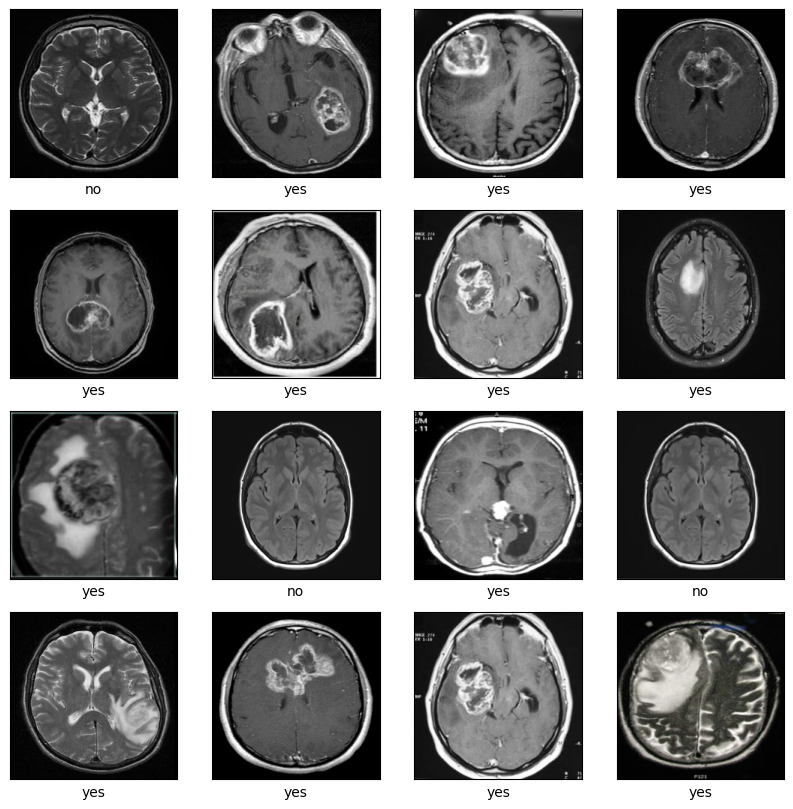

In [ ]:
# Function to display images as subplots
def display_images(images, labels, class_names, num_images=16):
    plt.figure(figsize=(10, 10))
    indices = np.random.choice(range(len(images)), num_images, replace=False)
    for i, idx in enumerate(indices):
        plt.subplot(4, 4, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[idx])
        plt.xlabel(class_names[np.argmax(labels[idx])])
    plt.show()

# Display a random selection of training images
display_images(X, Y, classes)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
# Split the data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
# Load the pre-trained VGG16 and InceptionV3 models
base_model1 = VGG16(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
base_model2 = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

87910968/87910968 [==============================] - 3s 0us/step


In [ ]:
# Create the hybrid model
x1 = base_model1.output
x1 = GlobalAveragePooling2D()(x1)
x1 = Dense(1024, activation='relu')(x1)
x1 = Dropout(0.5)(x1)
predictions1 = Dense(len(classes), activation='sigmoid')(x1)

x2 = base_model2.output
x2 = GlobalAveragePooling2D()(x2)
x2 = Dense(1024, activation='relu')(x2)
x2 = Dropout(0.5)(x2)
predictions2 = Dense(len(classes), activation='sigmoid')(x2)

model = Model(inputs=[base_model1.input, base_model2.input], outputs=[predictions1, predictions2])

In [ ]:
# Freeze the layers in the pre-trained models
for layer in base_model1.layers:
    layer.trainable = False

for layer in base_model2.layers:
    layer.trainable = False

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'],run_eagerly=True)

In [ ]:
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("Y_train shape:", Y_train.shape)
print("Y_val shape:", Y_val.shape)

X_train shape: (202, 224, 224, 3)
X_val shape: (51, 224, 224, 3)
Y_train shape: (202, 2)
Y_val shape: (51, 2)


In [ ]:
history = model.fit([X_train, X_train], [Y_train, Y_train],epochs=2, validation_data=([X_val, X_val], [Y_val, Y_val]))

Epoch 1/2
7/7 [==============================] - 610s 87s/step - loss: 7.7468 - dense_1_loss: 0.4181 - dense_3_loss: 7.3287 - dense_1_accuracy: 0.9010 - dense_3_accuracy: 0.7079 - val_loss: 6.3400 - val_dense_1_loss: 1.0151 - val_dense_3_loss: 5.3249 - val_dense_1_accuracy: 0.8627 - val_dense_3_accuracy: 0.7843
Epoch 2/2
7/7 [==============================] - 601s 86s/step - loss: 7.0305 - dense_1_loss: 0.4343 - dense_3_loss: 6.5962 - dense_1_accuracy: 0.8861 - dense_3_accuracy: 0.7178 - val_loss: 3.7706 - val_dense_1_loss: 0.9943 - val_dense_3_loss: 2.7763 - val_dense_1_accuracy: 0.8627 - val_dense_3_accuracy: 0.7647


In [ ]:


# Evaluate the model
score = model.evaluate([X_val, X_val], [Y_val, Y_val], verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

Validation loss: 3.7706284523010254
Validation accuracy: 0.9943128228187561


Epoch 1/15
7/7 [==============================] - 230s 31s/step - loss: 12.0545 - accuracy: 0.5347 - val_loss: 6.3554 - val_accuracy: 0.6078
Epoch 2/15
7/7 [==============================] - 254s 38s/step - loss: 6.9911 - accuracy: 0.5990 - val_loss: 2.4164 - val_accuracy: 0.7647
Epoch 3/15
7/7 [==============================] - 253s 38s/step - loss: 4.6848 - accuracy: 0.7178 - val_loss: 3.9605 - val_accuracy: 0.7647
Epoch 4/15
7/7 [==============================] - 215s 31s/step - loss: 4.7968 - accuracy: 0.7030 - val_loss: 4.1049 - val_accuracy: 0.7647
Epoch 5/15
7/7 [==============================] - 215s 31s/step - loss: 3.3105 - accuracy: 0.7772 - val_loss: 2.8466 - val_accuracy: 0.7647
Epoch 6/15
7/7 [==============================] - 255s 38s/step - loss: 4.9274 - accuracy: 0.7376 - val_loss: 2.8527 - val_accuracy: 0.7843
Epoch 7/15
7/7 [==============================] - 255s 38s/step - loss: 3.5498 - accuracy: 0.7673 - val_loss: 3.8420 - val_accuracy: 0.7843
Epoch 8/15
7/7 [===

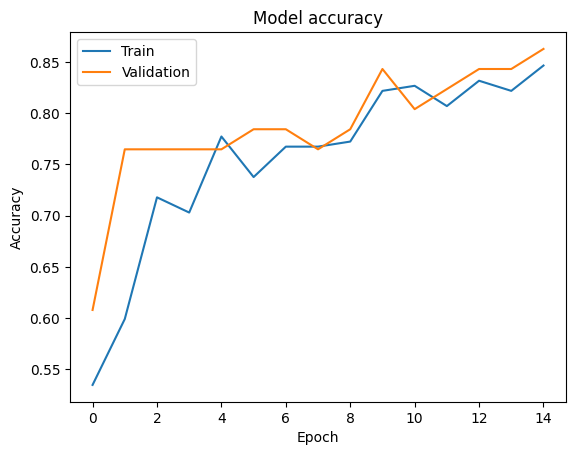

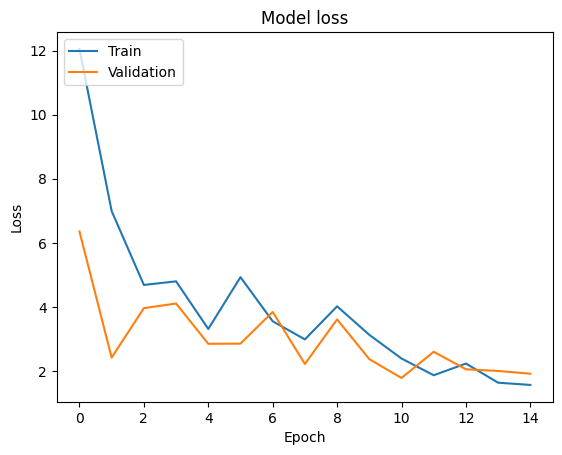

In [ ]:
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, concatenate
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16, InceptionV3
from tensorflow.keras.optimizers import Adam

X_train = tensorflow.image.resize(X_train, (244, 244))
X_val = tensorflow.image.resize(X_val, (244, 244))

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(X_train, Y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, Y_val, batch_size=32)

# Load pre-trained VGG16 and InceptionV3 models
base_model1 = VGG16(weights='imagenet', include_top=False, input_shape=(244,244, 3))
base_model2 = InceptionV3(weights='imagenet', include_top=False, input_shape=(244,244, 3))

# Freeze the layers in the pre-trained models
for layer in base_model1.layers:
    layer.trainable = False
for layer in base_model2.layers:
    layer.trainable = False

# Build a custom head for the combined model
x1 = base_model1.output
x1 = GlobalAveragePooling2D()(x1)
x1 = Dense(1024, activation='relu')(x1)
x1 = Dropout(0.5)(x1)

x2 = base_model2.output
x2 = GlobalAveragePooling2D()(x2)
x2 = Dense(1024, activation='relu')(x2)
x2 = Dropout(0.5)(x2)

# Concatenate the outputs of both models
combined = concatenate([x1, x2])
combined_output = Dense(1024, activation='relu')(combined)
combined_output = Dropout(0.5)(combined_output)
predictions = Dense(len(classes), activation='softmax')(combined_output)

# Combine the model
model = Model(inputs=[base_model1.input, base_model2.input], outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit([X_train, X_train], Y_train, epochs=5, validation_data=([X_val, X_val], [Y_val, Y_val]))

# Evaluate the model
loss, accuracy = model.evaluate([X_val, X_val], Y_val, verbose=0)
print('Validation loss:', loss)
print('Validation accuracy:', accuracy)

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()